# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
import torch
import numpy as np
import PIL
import random
import os
import time

train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [2]:
from torch.utils.data.dataset import ConcatDataset
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']       # сами объекты датасетов для train и val по своей структуре не будут отличаться, они оба размечены

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [4]:
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset/')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))    # рекурсивно собирает все файлы из указанной директории формата jpg
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(len(train_val_files))
print(len(test_files))

20933
991


Ниже  исспользуем враппер над датасетом для удобной работы. Стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [5]:
class SimpsonsDataset(Dataset):
    """
    Класс датасета с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры

    Особенность нашего случая в том, что метки классов содержатся в названиях картинок, а не в
    отдельном цсв файле
    """
    def __init__(self, files, mode, transform=None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.transform = transform

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]     # извлекаем все возможные классы из названий картинок
            self.label_encoder.fit(self.labels)     # лейбл энкодер фитим на этих названиях классов

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)     # функция, позволяющая записывать объект в файл
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        ''' По пути к картинке возвращает PIL Image '''
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # Датасет у нас хранится в виде некоторых картинок, но как только мы достаем из него элемент с ним делается __getitem__
        transform = self.transform
        if transform is None:
            transform = transforms.Compose([
            transforms.ToTensor(),      # кстати totensor приводит итак все величины к от 0 до 1
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # видимо по каждому каналу уже были посчитаны
            ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')    # это вообще лишнее действие - оно в ToTensor делается, а с np.array плохо трансформации работают
        x = transform(x)
        if self.mode == 'test':
            return x        # если тестовый датасет, то возвращаем чисто тензор нормализованный по каналам
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()

            return x, y     # возвращает элемент датасета в виде нормализованного по каналам торч тензора и его метки
        
    def _prepare_sample(self, image):
        ''' рескейлит PIL Image '''
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image
        # return image        # гораздо лучше PIL Image возвращать, потому что с ним все трансформации работают

 посмотреть наличие директорий можно посмотреть командой !ls, 
 
 а путь в текущую директорию командой !pwd, 
 
 разархивировать файл можно командой !unzip, документация по Каглу здесь 

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [8]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

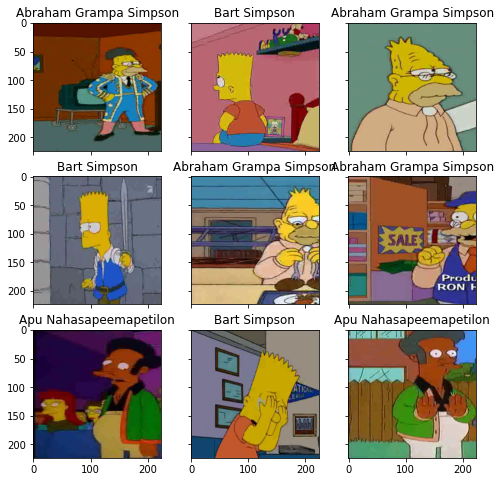

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [10]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [12]:
from torch.optim import lr_scheduler
def fit_epoch(model, train_loader, criterion,sheduler,optimizer): # Добавил для оптимизатора sheduler

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    sheduler.step() # # Добавил для оптимизатора sheduler

  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [13]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [15]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        
        opt = torch.optim.Adam(model.parameters(), lr=3e-4) # Добавил оптимизатор

        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1) # Добавил оптимизатор

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion,exp_lr_scheduler ,opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [17]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [18]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [19]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss 2.754092048600917


epoch:  50%|█████     | 1/2 [05:02<05:02, 302.06s/it]


Epoch 001 train_loss: 2.7541     val_loss 2.2904 train_acc 0.2337 val_acc 0.3642
loss 2.03033768914294


epoch: 100%|██████████| 2/2 [08:19<00:00, 249.57s/it]


Epoch 002 train_loss: 2.0303     val_loss 1.8510 train_acc 0.4432 val_acc 0.4897


Построим кривые обучения

In [20]:
loss, acc, val_loss, val_acc = zip(*history)

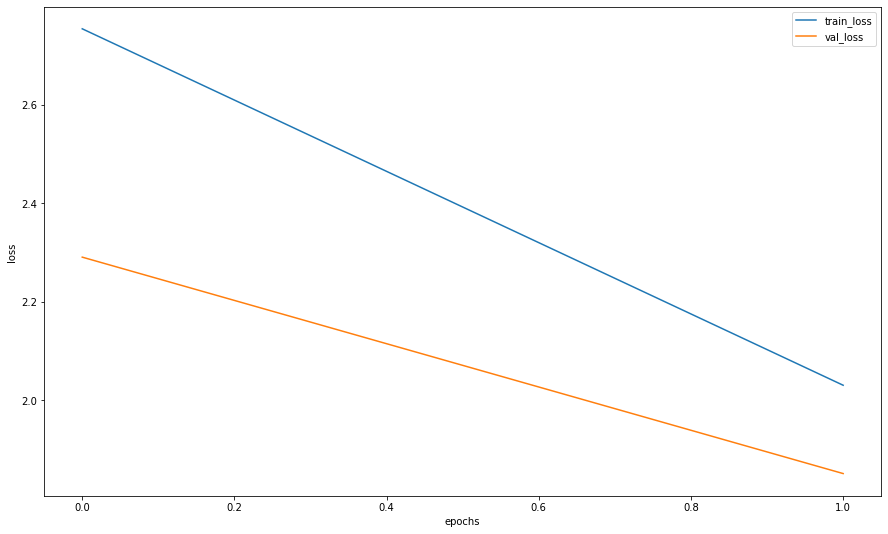

In [21]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [22]:
# библиотеки с разлчиными архетектурами https://pytorch.org/vision/stable/models/efficientnet.html

In [23]:
from torchvision import models

# my_efficientnet_b0

In [24]:
my_efficientnet_b0 = models.efficientnet_b0(pretrained=True).to(DEVICE)# Скач пред обуч модель с какимето весами

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [25]:
my_efficientnet_b0.classifier[1]=nn.Linear(1280,42)
my_efficientnet_b0.classifier[1]

Linear(in_features=1280, out_features=42, bias=True)

In [26]:
# Замораживаю нейроны 
for param in my_efficientnet_b0.features[:-5].parameters():
    param.requires_grad = False

In [27]:
history = train(train_dataset, val_dataset, model=my_efficientnet_b0.to(DEVICE), epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.8648244033832369


epoch:  10%|█         | 1/10 [03:41<33:16, 221.79s/it]


Epoch 001 train_loss: 0.8648     val_loss 0.2267 train_acc 0.8066 val_acc 0.9421
loss 0.1881023246598103


epoch:  20%|██        | 2/10 [07:23<29:33, 221.75s/it]


Epoch 002 train_loss: 0.1881     val_loss 0.2081 train_acc 0.9513 val_acc 0.9478
loss 0.06639883161626679


epoch:  30%|███       | 3/10 [11:05<25:54, 222.01s/it]


Epoch 003 train_loss: 0.0664     val_loss 0.1822 train_acc 0.9826 val_acc 0.9570
loss 0.047688866747576796


epoch:  40%|████      | 4/10 [14:47<22:12, 222.05s/it]


Epoch 004 train_loss: 0.0477     val_loss 0.1880 train_acc 0.9865 val_acc 0.9620
loss 0.03365623823066763


epoch:  50%|█████     | 5/10 [18:30<18:30, 222.16s/it]


Epoch 005 train_loss: 0.0337     val_loss 0.1743 train_acc 0.9896 val_acc 0.9576
loss 0.02834921840782866


epoch:  60%|██████    | 6/10 [22:12<14:48, 222.01s/it]


Epoch 006 train_loss: 0.0283     val_loss 0.3015 train_acc 0.9915 val_acc 0.9410
loss 0.004119409216738452


epoch:  70%|███████   | 7/10 [25:52<11:05, 221.67s/it]


Epoch 007 train_loss: 0.0041     val_loss 0.1587 train_acc 0.9990 val_acc 0.9723
loss 0.0009060751102422432


epoch:  80%|████████  | 8/10 [29:34<07:23, 221.73s/it]


Epoch 008 train_loss: 0.0009     val_loss 0.1609 train_acc 0.9999 val_acc 0.9723
loss 0.0006336567141308226


epoch:  90%|█████████ | 9/10 [33:16<03:41, 221.58s/it]


Epoch 009 train_loss: 0.0006     val_loss 0.1648 train_acc 0.9998 val_acc 0.9727
loss 0.0005192656563486412


epoch: 100%|██████████| 10/10 [36:58<00:00, 221.80s/it]


Epoch 010 train_loss: 0.0005     val_loss 0.1679 train_acc 0.9999 val_acc 0.9721


# Графики по лучшей  модели

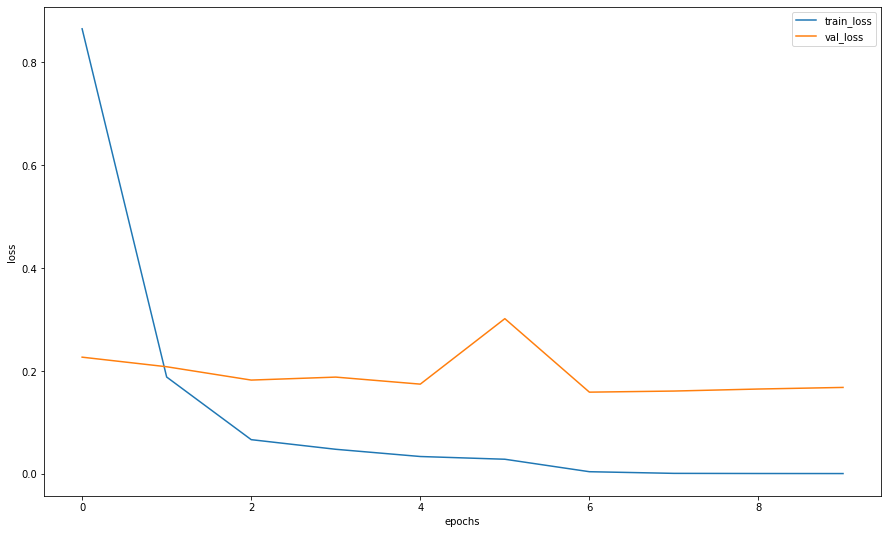

In [28]:

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


# Здесь модель меняю

In [30]:
model_rec=my_efficientnet_b0

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [31]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [32]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_rec, ex_img.unsqueeze(0)) # Вот здесь проверь

In [33]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_rec, imgs)

In [34]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [35]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [36]:
from sklearn.metrics import f1_score

#f1_score(actual_labels, preds_class)
f1_score(actual_labels, y_pred,average='micro')


0.85

0.85 получил на  my_model_vgg16_bn_3 на 10 эпохах и заморозкой 1-ые 5-ть слоев

1.0 получил на my_efficientnet_b0 на 10 эпохах и заморозкой 1-ые 5-ть слоев

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

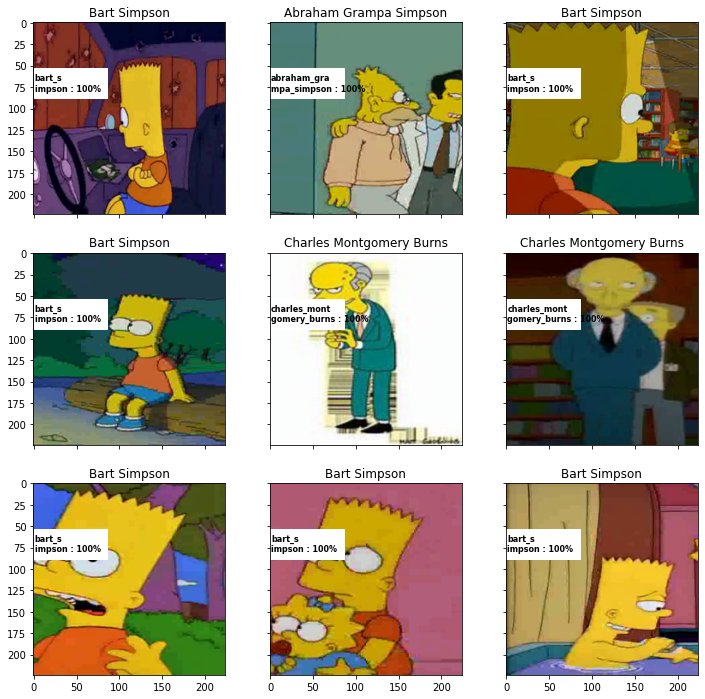

In [37]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_rec, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [38]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_rec, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [39]:
! ls 

__notebook_source__.ipynb  label_encoder.pkl


In [40]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
## my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
#my_submit.head()

my_submit = pd.DataFrame()
my_submit['Id'] = test_filenames
my_submit['Expected'] = preds
my_submit.to_csv('.//sample_submission.csv', index=False)

In [41]:
my_submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [42]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [43]:
#my_submit.to_csv('gdrive/My Drive/simpsons/simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
